# Notes

In [65]:
# conv-nets
# mainly work on image data, apply convolutional filters

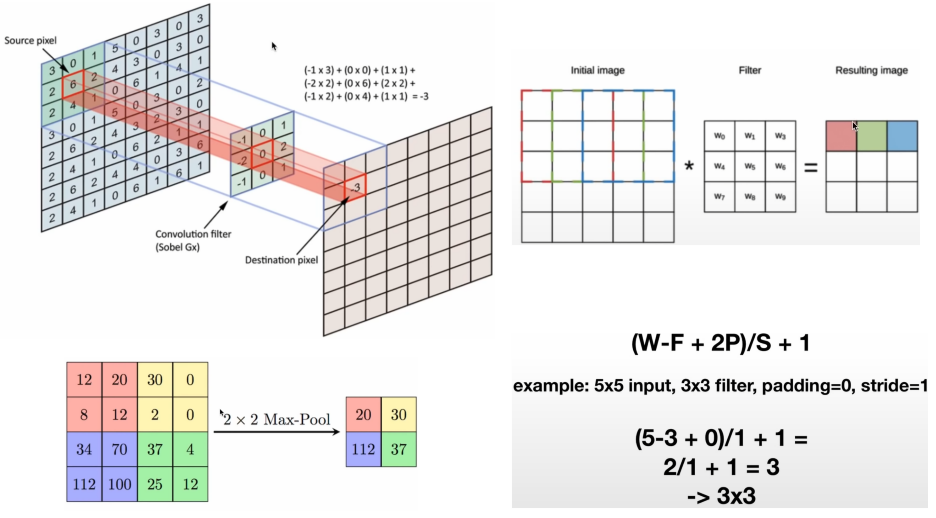

- used to reduce the computation by reducing the size of the image. (Reduces the no. of parameters to be learned.)

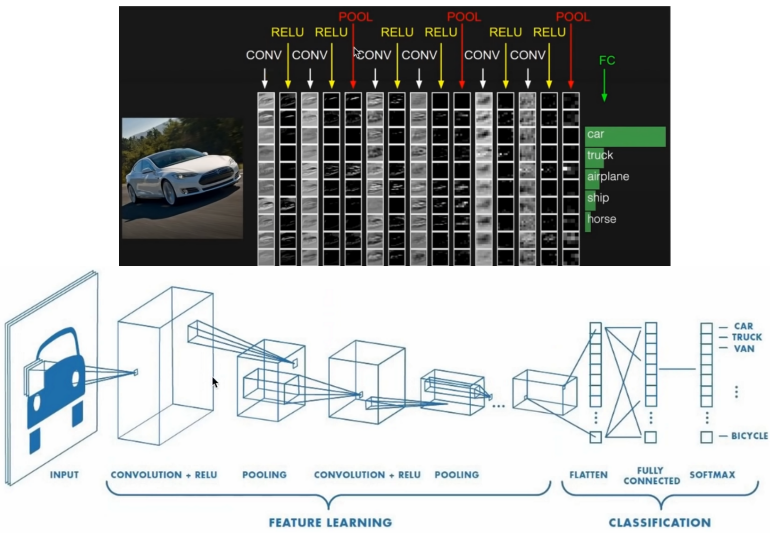

# Code

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [67]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [68]:
# Hyper-Parameters

num_epochs = 4
batch_size = 4
learning_rate = 0.01

In [69]:
# Transforms

# Normalize is used to normalize the image data by subtracting the mean and dividing by the standard deviation. 
# helps in standardizing the pixel values across different channels and brings them to a similar scale.

# dataset has PILImage images of range[0,1].
# We transform them to Tensors of normalized range[-1,1] {IMP}

# we apply Normalize transform to image dataset with three channels (e.g., RGB images). 
# The first tuple (0.5, 0.5, 0.5) represents the mean values for each channel, 
# and the second tuple (0.5, 0.5, 0.5) represents the standard deviation for each channel.

# To perform the normalization, the transform subtracts the mean values (0.5, 0.5, 0.5) from each channel and 
# then divides the result by the corresponding standard deviation values (0.5, 0.5, 0.5).

composed = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [70]:
# Data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=composed)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=composed)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # [4, 3, 32, 32]
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


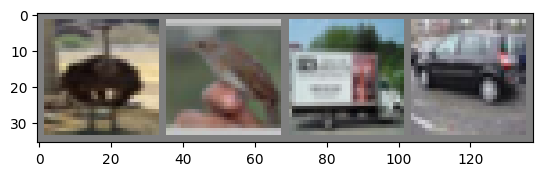

In [71]:
# plot
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [72]:
# Model

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 color channels, output is 6, kernel is 5
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # n is no. of samples
        # -> [n, 3, 32, 32]
        out = self.pool(F.relu(self.conv1(x)))    # -> [n, 6, 14, 14]
        out = self.pool(F.relu(self.conv2(out)))  # -> [n, 16, 5, 5]
        out = out.view(-1, 16*5*5)                # -> [n, 16*5*5] == [n, 400] # flatten it
        out = F.relu(self.fc1(out))               # -> [n, 120]
        out = F.relu(self.fc2(out))               # -> [n, 84]
        out = self.fc3(out)                       # -> [n, 10]
        return out 
        
model = ConvNet().to(device)

In [73]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [74]:
# Training Loop
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # original shape: [4, 3, 32, 32]
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)

        # loss
        loss = criterion(outputs, labels)

        # backward
        loss.backward()

        # update
        optimizer.step()

        # zero gradients
        optimizer.zero_grad()
        
        if (i+1)%2000 == 0:
            print('Epoch {}/{} Step {}/{} loss {:.4f}'.format(epoch+1, num_epochs, i+1, total_steps, loss.item()))

Epoch 1/4 Step 2000/12500 loss 1.7915
Epoch 1/4 Step 4000/12500 loss 1.8738
Epoch 1/4 Step 6000/12500 loss 1.6122
Epoch 1/4 Step 8000/12500 loss 1.6705
Epoch 1/4 Step 10000/12500 loss 3.1719
Epoch 1/4 Step 12000/12500 loss 1.3229
Epoch 2/4 Step 2000/12500 loss 0.8662
Epoch 2/4 Step 4000/12500 loss 2.1284
Epoch 2/4 Step 6000/12500 loss 0.4531
Epoch 2/4 Step 8000/12500 loss 1.2686
Epoch 2/4 Step 10000/12500 loss 1.6198
Epoch 2/4 Step 12000/12500 loss 1.1546
Epoch 3/4 Step 2000/12500 loss 0.6971
Epoch 3/4 Step 4000/12500 loss 1.2482
Epoch 3/4 Step 6000/12500 loss 1.0433
Epoch 3/4 Step 8000/12500 loss 1.6368
Epoch 3/4 Step 10000/12500 loss 0.3099
Epoch 3/4 Step 12000/12500 loss 1.1633
Epoch 4/4 Step 2000/12500 loss 1.0663
Epoch 4/4 Step 4000/12500 loss 1.0209
Epoch 4/4 Step 6000/12500 loss 1.5442
Epoch 4/4 Step 8000/12500 loss 2.7407
Epoch 4/4 Step 10000/12500 loss 0.8894
Epoch 4/4 Step 12000/12500 loss 0.5366


In [75]:
# Test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted==labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label==pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            
    acc = 100.0 * n_correct / n_samples
    print('Accuracy: ', acc)
    
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print('Accuracy of {}: {}%'.format(classes[i], acc))

Accuracy:  60.09
Accuracy of plane: 66.8%
Accuracy of car: 71.9%
Accuracy of bird: 42.0%
Accuracy of cat: 32.5%
Accuracy of deer: 54.9%
Accuracy of dog: 39.3%
Accuracy of frog: 79.5%
Accuracy of horse: 66.3%
Accuracy of ship: 76.1%
Accuracy of truck: 71.6%
